#  Assignment 2 Data Analysis: Recommendation System for Baby Products (13) 
## Ficara Damiano, Marenco Turi Gualtiero 


## Imports

This section is critical for importing all the libraries needed to execute the code; it was decided to put all the libraries in one section so that we would not forget to import something and have import problems.
To install the surprise library for matrix factorization, it was necessary to manually adjust the version of NumPy. The current release of NumPy (2.0.2) is incompatible with scikit-surprise, which has not yet been updated to support this major version change. As a workaround, we explicitly downgraded NumPy to an old version

In [1]:
!pip install numpy==1.24.4
!pip install surprise

In [5]:
# Imports to run the code
#from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split as surprise_split, GridSearchCV
import pandas as pd
import ast
from sklearn.feature_extraction.text import TfidfVectorizer

**READ THIS!!!**
While we used colab for sharing and working remote, trying to run this on Colab without Premium will result in using all available ram midway through it. Run this notebook locally!


In [3]:
#upload files 4 colab
#uploaded = files.upload()

# Data Pre-processing : Load and Explore Data

Load metadata (very large file). Initially attempted using ```json.loads()```, but due to inconsistent formatting in the file e.g., single quotes, trailing commas), we switched to ast.literal_eval for robustness. ast is more tolerant and safely parses each line as a Python dict.

In [6]:
#meta data loading, it'very heavy
data = []
with open("meta_Baby.json", "r") as f:
    for i, line in enumerate(f):
        try:
            obj = ast.literal_eval(line)
            data.append(obj)
        except Exception as e:
            print(f"Error at row {i}: {e}")
meta_df = pd.DataFrame(data)

In [ ]:
meta_df

,asin,categories,description,title,price,imUrl,brand,related,salesRank
0,0188399313,[[Baby]],Wee-Go Glass baby bottles by LifeFactory (Baby...,Lifefactory 4oz BPA Free Glass Baby Bottles - ...,69.99,http://ecx.images-amazon.com/images/I/41Swthpd...,Lifefactory,"{'also_bought': ['B002SG7K7A', 'B003CJSXW8', '...",NaN
1,0188399518,[[Baby]],The Planet Wise Flannel Wipes are 10 super sof...,Planetwise Flannel Wipes,15.95,http://ecx.images-amazon.com/images/I/41otjnA4...,Planet Wise,"{'also_bought': ['B00G96N3YY', 'B003XSEV2O', '...",NaN
2,0188399399,[[Baby]],The Planet Wise Wipe PouchTM features our pate...,Planetwise Wipe Pouch,10.95,http://ecx.images-amazon.com/images/I/61x8h9u6...,NaN,"{'also_bought': ['B005WWI0DA', 'B005WWIMGA', '...",NaN
3,0316967297,[[Baby]],Hand crafted set includes 1 full quilt (76x86 ...,Annas Dream Full Quilt with 2 Shams,109.95,http://ecx.images-amazon.com/images/I/51%2BZ1%...,NaN,"{'also_viewed': ['B009LTER3W', 'B00575TI5Q', '...",NaN
4,0615447279,[[Baby]],Thumbuddy To Love- The Binky Fairy helps child...,Stop Pacifier Sucking without tears with Thumb...,16.95,http://ecx.images-amazon.com/images/I/51RKKENl...,,"{'also_bought': ['0979670004', '1601310234', '...",NaN
...,...,...,...,...,...,...,...,...,...
71312,B00LL4K3GU,[[Baby]],Abstract Soft Spout Training is an ideal optio...,Abstract 2 PK Baby / Toddler Training Cup (Pink),NaN,http://ecx.images-amazon.com/images/I/41wXwyCd...,NaN,NaN,NaN
71313,B00LLEOSUW,[[Baby]],Introducing the Tutti Bimbi Baby Food Freezer ...,"Baby Food Freezer Tray - Bacteria Resistant, B...",17.95,http://ecx.images-amazon.com/images/I/31HI7L%2...,NaN,"{'also_viewed': ['B0027UYT4O', 'B004A9ZF3Y', '...",NaN
71314,B00LPFHMNM,[[Baby]],"With a new packaging, our best-selling shampoo...",Shampoo Fudge Clean Blonde Violet Toning Shamp...,NaN,http://ecx.images-amazon.com/images/I/41sFcpvs...,NaN,"{'also_viewed': ['B003Z922MC', 'B001W6Q2KS', '...",NaN
71315,B00LQXWHXI,[[Baby]],"The Best Baby Shade Ever!""I have never been ha...",Best 2 Pack Baby Car Shade for Kids - Window S...,9.96,http://ecx.images-amazon.com/images/I/41LGiDVu...,NaN,"{'also_viewed': ['B00K80DFUY', 'B00KF2SCMQ', '...",NaN


We decided to rename the columns of the ratings dataset because the original file lacks headers and uses positional data only. To improve readability and usability throughout the analysis, we assigned meaningful names: `user`, `item`, `rating`, and `timestamp`, corresponding respectively to the user ID, product ASIN, rating value, and the time of the interaction.


In [7]:
# load ratings dataset
ratings = pd.read_csv("ratings_Baby.csv", names=['user', 'item', 'rating', 'timestamp']) #unnamed variables are now named

print("Ratings dataset:")
print(ratings.head())

Ratings dataset:
             user        item  rating   timestamp
0  A28O3NP6WR5517  0188399313     5.0  1369612800
1   AX0M1Z6ZWO52J  0188399399     5.0  1365465600
2  A1KD7N84L7NIUT  0188399518     4.0  1392336000
3  A29CUDEIF4X1UO  0188399518     3.0  1373241600
4  A32592TYN6C9EM  0316967297     4.0  1378425600


To facilitate quick access to product titles from their ASINs, we built a dictionary mapping each `asin` to its corresponding `title` from the metadata. This mapping helps in displaying readable product names during analysis or recommendation explanation. We also print an example to confirm the mapping works as expected.


In [8]:
#Metadata preprocessing
asin_to_title = dict(zip(meta_df['asin'], meta_df['title']))
print(f"Number of titles loaded: {len(asin_to_title)}")
example_item = ratings['item'].iloc[0]
print(f"\n Example ASIN: {example_item}")

title = asin_to_title.get(example_item, "Title not found")
print(f"Title: {title}")


Number of titles loaded: 71317

 Example ASIN: 0188399313
Title: Lifefactory 4oz BPA Free Glass Baby Bottles - 4-pack-raspberry and Lilac


In [9]:
# Check for missing values in the ratings dataset.This step ensures data quality before proceeding with modeling.
# Since there are no missing values, we skip imputation.
missing_values = ratings.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# No imputation is needed in this case
# ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())


Missing values in each column:
user         0
item         0
rating       0
timestamp    0
dtype: int64


# Data Description


We begin with a descriptive analysis of the ratings dataset to understand its overall structure. We examine the number of unique users and products, the distribution of ratings, and the frequency of ratings per item and per user. 

In [10]:
# Display general info and descriptive statistics of the ratings dataset
# This provides a first overview of the structure, types, and distributions of the data
print("Ratings Info:")
print(ratings.info())
print("\nRatings Summary Stats:")
print(ratings.describe())

# Count number of unique users and products (ASINs)
print(f"Number of users: {ratings['user'].nunique()}")
print(f"Number of products: {ratings['item'].nunique()}")

Ratings Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915446 entries, 0 to 915445
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user       915446 non-null  object 
 1   item       915446 non-null  object 
 2   rating     915446 non-null  float64
 3   timestamp  915446 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 27.9+ MB
None

Ratings Summary Stats:
              rating     timestamp
count  915446.000000  9.154460e+05
mean        4.117695  1.336331e+09
std         1.289458  7.284112e+07
min         1.000000  9.653472e+08
25%         4.000000  1.311811e+09
50%         5.000000  1.361750e+09
75%         5.000000  1.386288e+09
max         5.000000  1.406074e+09
Number of users: 531890
Number of products: 64426


Ratings Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915446 entries, 0 to 915445
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user       915446 non-null  object 
 1   item       915446 non-null  object 
 2   rating     915446 non-null  float64
 3   timestamp  915446 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 27.9+ MB
None

Ratings Summary Stats:
              rating     timestamp
count  915446.000000  9.154460e+05
mean        4.117695  1.336331e+09
std         1.289458  7.284112e+07
min         1.000000  9.653472e+08
25%         4.000000  1.311811e+09
50%         5.000000  1.361750e+09
75%         5.000000  1.386288e+09
max         5.000000  1.406074e+09
Number of users: 531890
Number of products: 64426


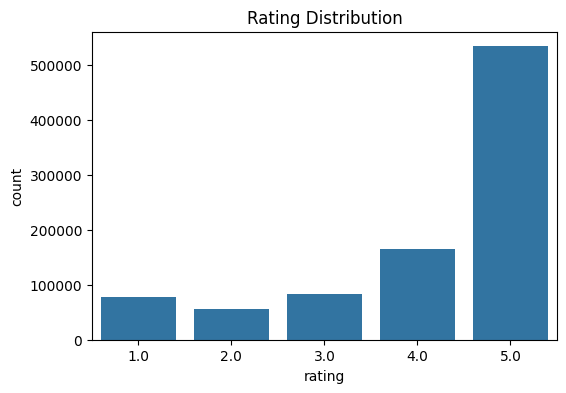

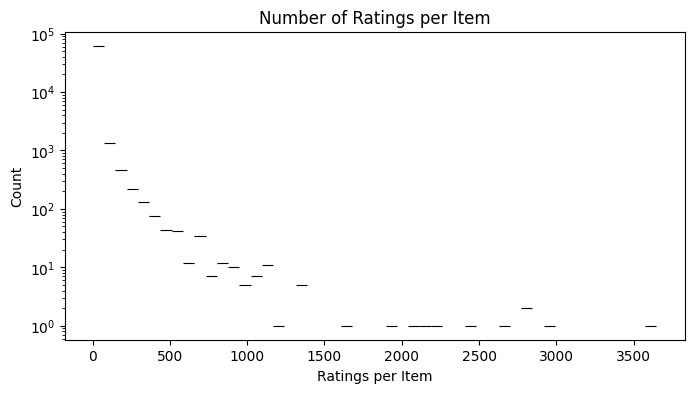

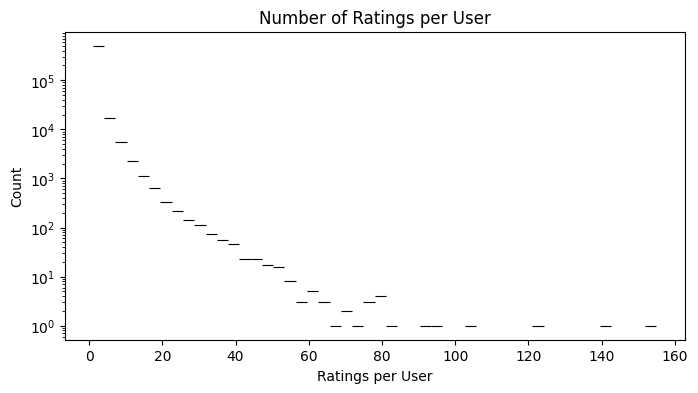


Timestamp Range:
2000-08-04 00:00:00 to 2014-07-23 00:00:00


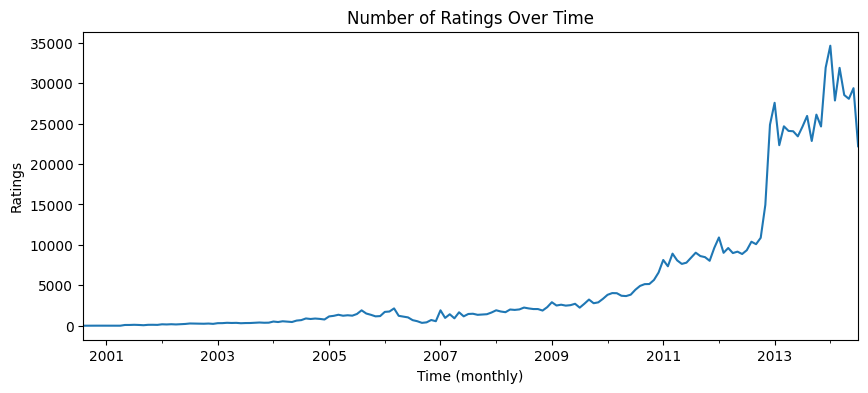

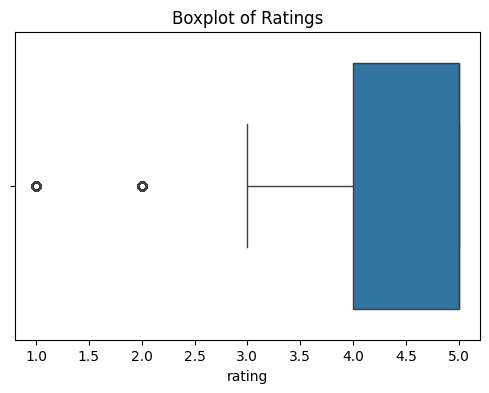

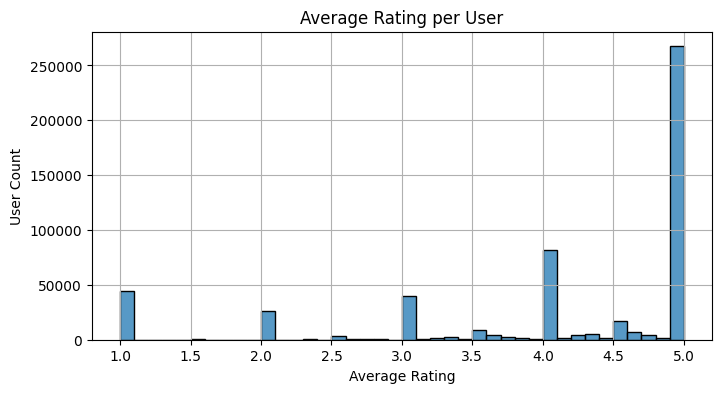

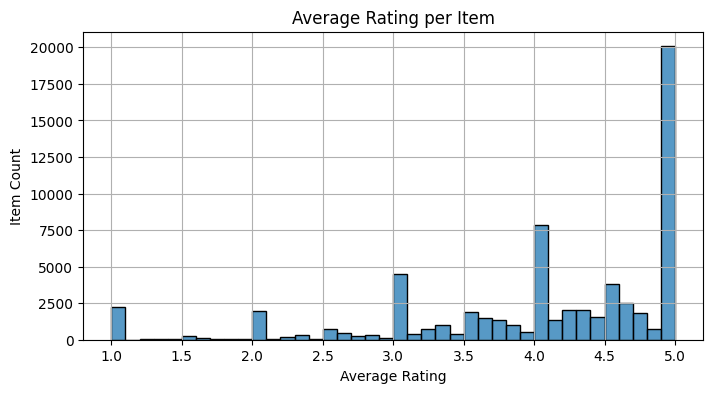

In [11]:
# Display general info and descriptive statistics of the ratings dataset
# This provides a first overview of the structure, types, and distributions of the data
print("Ratings Info:")
print(ratings.info())
print("\nRatings Summary Stats:")
print(ratings.describe())

# Count number of unique users and products (ASINs)
print(f"Number of users: {ratings['user'].nunique()}")
print(f"Number of products: {ratings['item'].nunique()}")

# Plot the overall distribution of rating values (e.g., how many 5-star vs. 1-star)
plt.figure(figsize=(6, 4))
sns.countplot(data=ratings, x='rating')
plt.title('Rating Distribution')
plt.show()

# Visualize how frequently each product has been rated
item_rating_counts = ratings['item'].value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(item_rating_counts, bins=50, log_scale=(False, True))
plt.title('Number of Ratings per Item')
plt.xlabel('Ratings per Item')
plt.show()

# Visualize how many ratings each user gave
user_rating_counts = ratings['user'].value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(user_rating_counts, bins=50, log_scale=(False, True))
plt.title('Number of Ratings per User')
plt.xlabel('Ratings per User')
plt.show()

# Convert UNIX timestamp to datetime to analyze temporal trends
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s', errors='coerce')
print("\nTimestamp Range:")
print(ratings['timestamp'].min(), "to", ratings['timestamp'].max())

# Plot how many ratings were made per month
plt.figure(figsize=(10, 4))
ratings['timestamp'].dt.to_period('M').value_counts().sort_index().plot()
plt.title('Number of Ratings Over Time')
plt.ylabel('Ratings')
plt.xlabel('Time (monthly)')
plt.show()

# Boxplot to examine potential skewness in rating values
plt.figure(figsize=(6, 4))
sns.boxplot(x=ratings['rating'])
plt.title('Boxplot of Ratings')
plt.show()

# Plot average rating per user to check user-specific bias
user_mean_ratings = ratings.groupby('user')['rating'].mean()
plt.figure(figsize=(8, 4))
sns.histplot(user_mean_ratings, bins=40)
plt.title('Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('User Count')
plt.grid(True)
plt.show()

# Plot average rating per item to check product-specific bias
item_mean_ratings = ratings.groupby('item')['rating'].mean()
plt.figure(figsize=(8, 4))
sns.histplot(item_mean_ratings, bins=40)
plt.title('Average Rating per Item')
plt.xlabel('Average Rating')
plt.ylabel('Item Count')
plt.grid(True)
plt.show()


### Most Frequently Rated Products

We identified the top 5 most rated products by counting the frequency of each `item` (ASIN) in the ratings dataset. Using the metadata, we then retrieved the corresponding product titles to better interpret which items were most popular or most frequently interacted with.


In [12]:
print("\nTop 5 Most Rated Products:")
most_rated_items = ratings['item'].value_counts().head(5)
print(most_rated_items)
print("\nTop 5 Product Titles by Rating Count:")
for asin in most_rated_items.index:
    print(meta_df[meta_df['asin'] == asin]['title'].values[0])




Top 5 Most Rated Products:
item
B000IDSLOG    3648
B000BNQC58    2923
B00295MQLU    2832
B0052QYLUM    2830
B000YDDF6O    2682
Name: count, dtype: int64

Top 5 Product Titles by Rating Count:
Vulli Sophie the Giraffe Teether
Cloud b Twilight Constellation Night Light, Turtle
Simple Wishes Hands-Free Breastpump Bra, Pink, XS-L
Infant Optics DXR-5 2.4 GHz Digital Video Baby Monitor with Night Vision
Baby Einstein Take Along Tunes


### Users with the Most Ratings

We identified the top 5 most active users by counting the number of ratings each user provided. This helps understand user engagement and potential outliers who may heavily influence model training due to their high activity.


In [13]:
print("\nTop 5 Most Active Users:")
print(ratings['user'].value_counts().head(5))



Top 5 Most Active Users:
user
ARIFCL50JD5SK     155
AJGU56YG8G1DQ     140
AF8SREA2XE7BJ     122
AJC88791BZEW7     105
A276OI0NHBYORX     95
Name: count, dtype: int64


To evaluate potential rating bias, we calculated the imbalance ratio between 5-star ratings and all other ratings. A high ratio (above 1.5) could indicate a strong skew toward positive reviews, potentially harming model generalization. In our case, the ratio was within acceptable limits, so no downsampling or rebalancing was required.


In [14]:
#computing imbalance ration (above 1.5 is considered bad)
rating_counts = ratings['rating'].value_counts().sort_index()
print(rating_counts)

five_star_df = ratings[ratings['rating'] == 5.0]
non_five_star_df = ratings[ratings['rating'] != 5.0]

imbalance_ratio = len(five_star_df) / len(non_five_star_df)
print(f"Imbalance ratio (5-stars / non-5): {imbalance_ratio:.2f}")
#it's okay then and we dont need to downsample

rating
1.0     76938
2.0     56322
3.0     82931
4.0    165123
5.0    534132
Name: count, dtype: int64
Imbalance ratio (5-stars / non-5): 1.40


We split the ratings dataset into training, evaluation, and test sets using an 80-10-10 split. This was done in two steps: first separating 80% for training and 20% as a temporary set. The temporary set was then evenly divided into evaluation and test sets. To simulate the real-world recommendation and the assignment task scenario, the `rating` column was removed from the evaluation and test sets, while the original values were preserved separately to compute prediction metrics.


In [15]:
# Split into 80% train and 20% temporary (for eval + test)
train_df, temp_df = train_test_split(ratings, test_size=0.2, random_state=42)

# Split the remaining 20% equally into 10% eval and 10% test
eval_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Keep copies of true ratings for evaluation and test
true_eval = eval_df.copy()
true_test = test_df.copy()

# Drop ratings to simulate the real prediction scenario
eval_df = eval_df.drop(columns=['rating'])
test_df = test_df.drop(columns=['rating'])

# Print sizes of each set
print("Train size:", len(train_df))
print("Eval size: ", len(eval_df))
print("Test size: ", len(test_df))


Train size: 732356
Eval size:  91545
Test size:  91545


# Recommendation systems

## Model 1 - Collaborative Filtering (Item-Item)

**Sparsity matrix**

We define a function to construct a sparse item-user matrix, where each row corresponds to a product (item) and each column to a user. The matrix cells contain rating values, and missing entries are implicitly set to zero. Additionally, we build two sets of mappings: one to convert user/item IDs to matrix indices, and their inverses to retrieve the original IDs from the matrix. These mappings are essential for interpreting predictions and computing similarities.


In [16]:
# create sparse item-user matrix for similarity calculation
def create_X(df):
    """
    - X, sparse item-user rating matrix (items as rows, users as columns),
    - user_mapper, dict mapping user IDs to matrix column indices,
    - item_mapper, dict mapping item IDs to matrix row indices,
    - their inverse for convenience
    """
    N = df['user'].nunique()
    M = df['item'].nunique()

    user_mapper = {u: i for i, u in enumerate(np.unique(df["user"]))}
    item_mapper = {i: j for j, i in enumerate(np.unique(df["item"]))}

    user_inv_mapper = {i: u for u, i in user_mapper.items()}
    item_inv_mapper = {j: i for i, j in item_mapper.items()}

    user_idx = [user_mapper[u] for u in df['user']]
    item_idx = [item_mapper[i] for i in df['item']]

    X = csr_matrix((df['rating'], (item_idx, user_idx)), shape=(M, N))

    return X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper



In [17]:
X_train, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper = create_X(train_df)
item_similarity = cosine_similarity(X_train)

We calculate the sparsity of the item-user matrix, which represents the proportion of observed ratings relative to all possible user-item combinations. This is a key characteristic of recommendation systems, where users typically interact with only a small subset of items.


In [18]:
sparsity = X_train.count_nonzero() / float(X_train.shape[0] * X_train.shape[1])
# Increased decimal precision to 6 digits (instead of 4) for a more accurate representation.
print(f"Matrix sparsity: {sparsity*100:.6f}%")


Matrix sparsity: 0.002733%


The `predict_rating1` function estimates how a user would rate a given item by computing a weighted average of the ratings the user has given to similar items. It uses item-item cosine similarity to determine how "close" other items are to the target. If the user has no prior ratings or no meaningful similarities are found, the function returns `NaN`.


In [19]:
def predict_rating1(user_id, item_id, X, item_similarity):
    """
    Takes:
    - user_id, ID of the user,
    - item_id, ID of the item,
    - X, sparse item-user rating matrix (items as rows, users as columns),
    - item_similarity: item-item similarity matrix.

    Outuput:
    - A predicted rating (float!) for the given user-item pair using item-based collaborative filtering
    """
    if user_id not in user_mapper or item_id not in item_mapper:
        return np.nan

    user_idx = user_mapper[user_id]
    item_idx = item_mapper[item_id]

    sim_vector = item_similarity[item_idx]  # take similarity of item_id with all other items
    user_ratings = X[:, user_idx].toarray().flatten()

    rated_indices = np.where(user_ratings > 0)[0]
    if len(rated_indices) == 0:
        return np.nan  # user has given 0 rating (shouldnt be possible but...)

    sims = sim_vector[rated_indices]
    ratings = user_ratings[rated_indices]

    if np.sum(sims) == 0:
        return np.nan  # not enough similar items to be meaningful

    return np.dot(sims, ratings) / np.sum(sims)

This function evaluates the performance of the item-based collaborative filtering model by comparing predicted ratings against true ones. It adds a `predicted_rating` column to the input DataFrame and calculates RMSE and MAE on valid predictions only. If no predictions are made (e.g., due to sparsity or cold-start), the function returns `None`.


In [20]:
def evaluate_model1(df_with_ratings, X, item_similarity):
    """
    Inputs:
    - df_with_ratings: the DataFrame
    - X: sparse item-user rating matrix,
    - item_similarity: item-item similarity matrix.

    Outputs:
    - df: the input DataFrame with an added 'predicted_rating' column,
    - rmse: root mean squared error of predictions,
    - mae: mean absolute error of predictions.
    """
    df = df_with_ratings.copy()
    tqdm.pandas()
    df['predicted_rating'] = df.progress_apply(
        lambda row: predict_rating1(row['user'], row['item'], X, item_similarity),
        axis=1
    )
    valid = df['predicted_rating'].notna()
    if valid.sum() == 0:
        print("No valid predictions.")
        return None

    rmse = mean_squared_error(df.loc[valid, 'rating'], df.loc[valid, 'predicted_rating'])
    mae = mean_absolute_error(df.loc[valid, 'rating'], df.loc[valid, 'predicted_rating'])
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    return df, rmse, mae

Training and eval of model 1

In [21]:
predicted_eval, eval_rmse, eval_mae = evaluate_model1(true_eval, X_train, item_similarity)


100%|██████████| 91545/91545 [01:05<00:00, 1394.30it/s]

RMSE: 1.8380
MAE: 0.8698


In [22]:
predicted_test, test_rmse, test_mae = evaluate_model1(true_test, X_train, item_similarity)

100%|██████████| 91545/91545 [01:06<00:00, 1384.13it/s]

RMSE: 1.8023
MAE: 0.8563


## Model 2 - Content-Based Filtering

To enhance the expressiveness of the content-based model, we combined product titles with their descriptions to generate richer text features. We truncated long descriptions to the first 50 words for consistency and efficiency. Using TF-IDF vectorization on this combined text, we computed item-to-item cosine similarities via the linear kernel. Only items with available metadata were kept, and users with just one rating were excluded to avoid cold-start effects.

We then evaluated prediction performance for various `top_k` values to study the trade-off between accuracy and coverage. Ratings were predicted using a weighted average of similar items the user has already rated.


In [23]:
# Combine title and description for a richer item representation
meta_clean = meta_df[['asin', 'title', 'description']].dropna(subset=['asin', 'title', 'description']).drop_duplicates(subset='asin')
meta_clean['short_desc'] = meta_clean['description'].str.split().str[:50].str.join(" ")
meta_clean['text'] = meta_clean['title'] + " " + meta_clean['short_desc']
meta_clean = meta_clean.sample(n=60000, random_state=42)

# Compute TF-IDF vectors using combined text
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(meta_clean['text'])
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix) ## cosine crash

# Mapping ASINs to index and back
asin_to_index = pd.Series(meta_clean.index, index=meta_clean['asin'])
index_to_asin = pd.Series(meta_clean['asin'].values, index=meta_clean.index)

In [24]:
# Filter ratings to items with metadata
ratings_cb = ratings[ratings['item'].isin(meta_clean['asin'])].copy()
ratings_cb = ratings_cb.drop_duplicates(subset=['user', 'item'])

# Optional: remove users with only 1 rating
user_counts = ratings_cb['user'].value_counts()
ratings_cb = ratings_cb[ratings_cb['user'].isin(user_counts[user_counts >= 1].index)]

# Reset index just in case
ratings_cb.reset_index(drop=True, inplace=True)

# Split into train, eval, test 
train_cb, temp_cb = train_test_split(ratings_cb, test_size=0.2, random_state=1)
eval_cb, test_cb = train_test_split(temp_cb, test_size=0.5, random_state=1)
test_cb = test_cb[test_cb['item'].isin(asin_to_index.index)].copy()
true_eval_cb = eval_cb.copy()
true_test_cb = test_cb.copy()

# Build lookup dictionary for training set
ratings_dict = {(row['user'], row['item']): row['rating'] for _, row in train_cb.iterrows()}


In [25]:
user_means = train_cb.groupby('user')['rating'].mean().to_dict()
global_mean = train_cb['rating'].mean()


In [26]:
# Predict rating using cosine similarity over title+description
def predict_content(user_id, item_id, top_k=500):
    if item_id not in asin_to_index:
        return np.nan
    idx = asin_to_index.get(item_id)
    if idx is None or idx >= cosine_sim.shape[0]:
        return np.nan

    sim_scores = list(enumerate(cosine_sim[idx]))
    #sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:top_k * 3]
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[:top_k * 5]


    sims, ratings = [], []
    for i, score in sim_scores:
        asin = index_to_asin.get(i)
        if asin is None:
            continue
        if (user_id, asin) in ratings_dict:
            sims.append(score)
            ratings.append(ratings_dict[(user_id, asin)])
        if len(sims) >= top_k:
            break

    if not sims or np.sum(sims) == 0:
        return user_means.get(user_id, global_mean)

    return np.dot(sims, ratings) / np.sum(sims)


In [ ]:
results = {}

print(f"Testing top_k={5}")
test_copy = test_cb.copy()
test_copy['predicted'] = test_copy.progress_apply(
    lambda row: predict_content(row['user'], row['item'], top_k=k), axis=1
)
test_copy["true_rating"] = true_test_cb["rating"].values
valid = test_copy['predicted'].notna()
rmse = mean_squared_error(test_copy.loc[valid, 'true_rating'], test_copy.loc[valid, 'predicted'])
mae = mean_absolute_error(test_copy.loc[valid, 'true_rating'], test_copy.loc[valid, 'predicted'])
print(f"top_k={5} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, Valid: {valid.sum()}/{len(test_copy)}\n")

results[5] = {'rmse': rmse, 'mae': mae, 'valid': valid.sum()}


Testing top_k=5


100%|██████████| 82115/82115 [19:13<00:00, 71.22it/s] 

top_k=5 → RMSE: 1.8999, MAE: 1.0137, Valid: 77484/82115



## Model 3 - Matrix Factorization (SVD)

We used the Surprise library to implement a matrix factorization model (SVD) and tuned its hyperparameters using grid search with 3-fold cross-validation.  After identifying the best configuration based on RMSE and MAE, we trained the final model on the training set and evaluated it on a separate test set. 

In [27]:
# Use Surprise library for matrix factorization with grid search tuning
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user', 'item', 'rating']], reader)
trainset, testset = surprise_split(data, test_size=0.2, random_state=42)

In [28]:
# Define hyperparameter search space
param_grid = {'n_factors': [50, 100], 'lr_all': [0.002, 0.005], 'reg_all': [0.02, 0.1], 'n_epochs': [20, 30]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)


In [29]:
# Display best hyperparameters and performance
print(f"Best Params: {gs.best_params['rmse']}")
print(f"Best RMSE: {gs.best_score['rmse']:.4f}, Best MAE: {gs.best_score['mae']:.4f}")


Best Params: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.1, 'n_epochs': 30}
Best RMSE: 1.1979, Best MAE: 0.9343


In [ ]:
# Train and evaluate the best model on test set
best_model = gs.best_estimator['rmse']
best_model.fit(trainset)
predictions = best_model.test(testset)
r1 = accuracy.rmse(predictions)
m1 = accuracy.mae(predictions)
print(f"Final SVD RMSE: {r1:.4f}, MAE: {m1:.4f}")

RMSE: 1.1937
MAE:  0.9317
Final SVD RMSE: 1.1937, MAE: 0.9317


## Utils

In [ ]:
# these are not in use rn but kept for eventual future reference
def predict_rating(user_id, item_id, X, item_similarity, top_k=5):
    if user_id not in user_mapper or item_id not in item_mapper:
        return np.nan

    user_idx = user_mapper[user_id]
    item_idx = item_mapper[item_id]

    sim_vector = item_similarity[item_idx]
    user_ratings = X[:, user_idx].toarray().flatten()

    rated_indices = np.where(user_ratings > 0)[0]
    if len(rated_indices) == 0:
        return np.nan

    sims = sim_vector[rated_indices]
    ratings = user_ratings[rated_indices]

    if len(sims) > top_k:
        top_k_idx = np.argsort(sims)[-top_k:]
        sims = sims[top_k_idx]
        ratings = ratings[top_k_idx]

    if np.sum(sims) == 0:
        return np.nan

    return np.dot(sims, ratings) / np.sum(sims)

#################################

def evaluate(df, true_df, name=""):
    df = df.copy()
    tqdm.pandas()
    df['predicted_rating'] = df.progress_apply(
        lambda row: predict_rating(row['user'], row['item'], X_train, item_similarity, top_k=5),
        axis=1
    )
    df['true_rating'] = true_df['rating'].values
    valid = df['predicted_rating'].notna()

    rmse = mean_squared_error(df.loc[valid, 'true_rating'], df.loc[valid, 'predicted_rating'])
    mae = mean_absolute_error(df.loc[valid, 'true_rating'], df.loc[valid, 'predicted_rating'])

    print(f"\n{name} Set Evaluation:")
    print(f"Valid predictions: {valid.sum()} / {len(df)}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    return df


eval_df = evaluate(eval_df, true_eval, name="Validation")
test_df = evaluate(test_df, true_test, name="Test")
#####################
